# Project Description

This project uses a combination of high-throughput density functional theory (DFT) data and experimental data on halide perovskite alloys to train predictive machine learning (ML) models using a variety of regression algorithms for properties of interest and perform multi-objective inverse design using genetic algorithm (GA).

DFT calculations are performed at two levels of theory: GGA-PBE (referred to as PBE henceforth) and HSE06 (referred to as HSE henceforth), leading to a DFT dataset of ~ 800 points. Three properties are computed: the decomposition energy (in eV per formula unit), the band gap (in eV), and the spectroscopic limited maximum efficiency (SLME, in fraction, indicating a theoretical limit for photovoltaic power conversion efficiency). Experimental data (band gap and PV efficiency) for around 100 points, collected from the literature, are further added to the dataset.  Every data point or compound is identified using an Index and a Formula. Two types of input descriptors are defined (to be used for training input -> output predictive models): a composition vector (14 dim) and a elemental properties vector (36 dim); one-hot encoded vectors representing the perovskite phase (cubic, tetragonal, orthorhombic, or hexagonal) and the source of data (PBE, HSE, Expt) are further added as descriptors. The data are divided into 4 types: PBE only, HSE only, PBE+HSE, and PBE+HSE+Expt.

This notebook calls relevant python packages, reads the DFT and/or experimental data, performs data visualization, and then has different sections for a variety of ML treatments including Pearson coefficients of linear correlation between descriptors and properties followed by regression models using elasticnet regression, random forest regression, and kernel ridge regression, and finally genetic algorithm to design novel perovskites with targeted properties.

To learn more, contact Arun Mannodi Kanakkithodi (amannodi@purdue.edu) or Jiaqi Yang (yang1494@purdue.edu).


The overall goal of this project is to learn from a multi-fidelity dataset (properties from DFT-PBE, DFT-HSE, and Experiment) of halide perovskite alloys in a variety of prototypical phases, and obtain predictive models for multiple properties at different fidelities. Best models are subsequently used for large-scale prediction and inverse design.

The main part of the tutorial begins here.

In [ ]:
import numpy as np     
import csv 
import copy 
import random
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model
# from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
# from geneticalgorithm2 import Population_initializer # for creating better start population
# from geneticalgorithm2 import np_lru_cache # for cache function (if u want)
# from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want
# from geneticalgorithm2 import Callbacks # simple callbacks
# from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

import warnings
warnings.filterwarnings("ignore")


In [87]:
###  Read Data  ###


Operation = 'Regression'
#Operation = 'GA'

##  Choose Dataset Type  ##
#Data = 'PBE'
#Data = 'HSE'
#Data = 'PBE_and_HSE'
Data = 'PBE_HSE_Expt'

##  Choose Descriptor Type  ##
#Desc = 'Composition Only'
#Desc = 'Elemental Only'
Desc = 'Composition and Elemental'



if Operation == 'Regression':

    if Data == 'PBE':
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Expt_desc.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Outside.csv
        D = read_csv('PBE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_2 = read_csv('Expt_desc.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_3 = read_csv('Outside.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Data == 'HSE':
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/HSE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Expt_desc.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Outside.csv
        D = read_csv('HSE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_2 = read_csv('Expt_desc.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_3 = read_csv('Outside.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        
    if Data == 'PBE_and_HSE':
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_and_HSE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Expt_desc_2.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Outside_2.csv
        D = read_csv('PBE_and_HSE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_2 = read_csv('Expt_desc_2.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_3 = read_csv('Outside_2.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Data == 'PBE_HSE_Expt':
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_HSE_expt_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Expt_desc_3.csv
        !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/Outside_3.csv
        D = read_csv('PBE_HSE_expt_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Index_2 = df.Index[0:885]
        Formula = df.Formula
        Formula_2 = df.Formula[0:885]
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME[0:885]
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_2 = read_csv('Expt_desc_3.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        
        D_3 = read_csv('Outside_3.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Desc == 'Composition Only':
        X = copy.deepcopy(Comp_desc)
        X_expt = copy.deepcopy(Comp_desc_expt)
        X_out = copy.deepcopy(Comp_desc_out)
    if Desc == 'Elemental Only':
        X = copy.deepcopy(Elem_desc)
        X_expt = copy.deepcopy(Elem_desc_expt)
        X_out = copy.deepcopy(Elem_desc_out)
    if Desc == 'Composition and Elemental':
        X = copy.deepcopy(All_desc)
        X_expt = copy.deepcopy(All_desc_expt)
        X_out = copy.deepcopy(All_desc_out)
    
    n = Index.size
    n_2 = Index_2.size
    m = int(X.size/n)
    dim = m
    X_2 = X[0:885]
    X_fl_1 = np.array(X, dtype="float32")
    X_fl_2 = np.array(X[0:885], dtype="float32")
    n_exp = int(X_expt.size/m)
    X_expt_fl = np.array(X_expt, dtype="float32")
    n_out = int(X_out.size/m)
    X_out_fl = np.array(X_out, dtype="float32")






if Operation == 'GA':
    
    !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_data.csv
    D = read_csv('PBE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
    Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

    if Desc == 'Composition Only':
        X_1 = copy.deepcopy(Comp_desc)
    if Desc == 'Elemental Only':
        X_1 = copy.deepcopy(Elem_desc)
    if Desc == 'Composition and Elemental':
        X_1 = copy.deepcopy(All_desc)
    n_1 = Index.size
    m_1 = int(X_1.size/n_1)
    X_fl_1 = np.array(X_1, dtype="float32")

    !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_HSE_expt_data.csv
    D = read_csv('PBE_HSE_expt_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Index_2 = df.Index[0:885]
    Formula = df.Formula
    Formula_2 = df.Formula[0:885]
#    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME[0:885]
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
    Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

    if Desc == 'Composition Only':
        X_2 = copy.deepcopy(Comp_desc)
    if Desc == 'Elemental Only':
        X_2 = copy.deepcopy(Elem_desc)
    if Desc == 'Composition and Elemental':
        X_2 = copy.deepcopy(All_desc)
    n_2 = Index.size
    n_3 = Index_2.size
    m_2 = int(X_2.size/n_2)
    X_3 = X_2[0:885]
    X_fl_2 = np.array(X_2, dtype="float32")
    X_fl_3 = np.array(X_3, dtype="float32")




zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


In [88]:
df

,Index,Formula,Decomp,Gap,SLME,K,Rb,Cs,MA,FA,...,X_MP,X_dens,X_at_wt,X_EA,X_IE,X_hof,X_hov,X_En,X_at_num,X_period
0,1,MAGeCl_3,-0.39,1.95,0.15,0.0,0.0,0.0,1.0,0.0,...,172.00,3.21,35.5,349.0,1250.0,3.21,10.20,3.16,17.0,3.0
1,2,MAGeBr_3,-0.24,1.61,0.20,0.0,0.0,0.0,1.0,0.0,...,266.00,3.12,79.9,325.0,1140.0,5.29,14.70,2.96,35.0,4.0
2,3,MAGeI_3,-0.03,1.31,0.23,0.0,0.0,0.0,1.0,0.0,...,387.00,4.93,127.0,295.0,1010.0,7.76,20.90,2.66,53.0,5.0
3,4,MASnCl_3,-0.25,1.58,0.17,0.0,0.0,0.0,1.0,0.0,...,172.00,3.21,35.5,349.0,1250.0,3.21,10.20,3.16,17.0,3.0
4,5,MASnBr_3,-0.23,1.26,0.20,0.0,0.0,0.0,1.0,0.0,...,266.00,3.12,79.9,325.0,1140.0,5.29,14.70,2.96,35.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,891,CsSn0.5Ge0.5I3,1000.00,1.69,1000.00,0.0,0.0,1.0,0.0,0.0,...,386.70,4.93,126.9,295.3,1008.4,7.76,20.90,2.66,53.0,5.0
891,892,CsSn_0.75Ge_0.25Br_3,1000.00,1.90,1000.00,0.0,0.0,1.0,0.0,0.0,...,265.95,3.12,79.9,324.6,1139.9,5.29,14.72,2.96,35.0,4.0
892,893,CsSn_0.5Ge_0.5Br_3,1000.00,2.00,1000.00,0.0,0.0,1.0,0.0,0.0,...,265.95,3.12,79.9,324.6,1139.9,5.29,14.72,2.96,35.0,4.0
893,894,CsSn_0.25Ge_0.75Br_3,1000.00,2.17,1000.00,0.0,0.0,1.0,0.0,0.0,...,265.95,3.12,79.9,324.6,1139.9,5.29,14.72,2.96,35.0,4.0


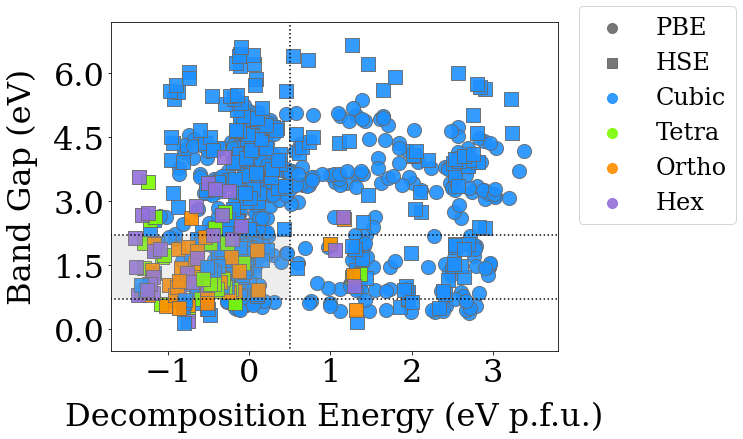

In [89]:
###   Visualize DFT Data, Decomp vs Gap    ###

n = len(df.Index[:])

fig = plt.figure( figsize=(10,6) )
plt.subplots_adjust(left=0.14, bottom=0.20, right=0.76, top=0.96)
plt.rc('font', family='serif')

for i in range(0,n):

#    if df.Expt[i] == 1:
#        plt.scatter(df.Decomp[i], Data.Gap[i], c='dodgerblue', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Cubic[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Tetra[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Ortho[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Hex[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Decomp[i], df.Gap[i], c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dimgrey', marker='o', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(1000, 1000, c='dimgrey', marker='s', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=100, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=100, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=100, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=100, edgecolors='mediumpurple', alpha=0.9, label='Hex')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [0.5,0.5,0.5]
d = [2.2,2.2,2.2]
plt.plot(b, a, c='k', ls=':')
plt.plot(b, d, c='k', ls=':')
plt.plot(c, b, c='k', ls=':')
x1 = np.arange(-1000, c[0],  0.01)

plt.fill_between(x1, a[0], d[0], facecolor='darkgrey', alpha=0.2)

plt.xlim([-1.7, 3.8])
plt.ylim([-0.5, 7.2])
plt.xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
plt.yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.xlabel('Decomposition Energy (eV p.f.u.)', fontsize=32, labelpad=12)
plt.ylabel('Band Gap (eV)', fontsize=32, labelpad=15)
plt.legend(bbox_to_anchor=(1.02,0.35), ncol=1, frameon=True, prop={'family':'serif','size':24})
#plt.savefig('plot_decomp_gap.pdf', dpi=450)



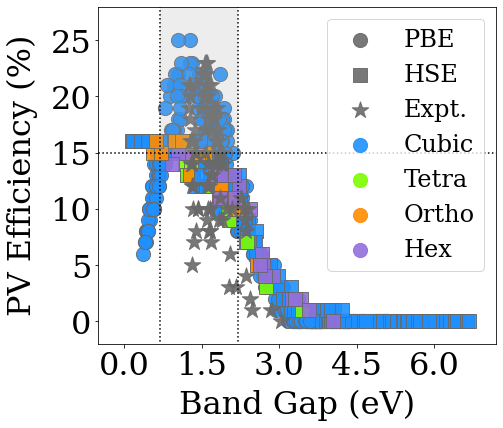

In [90]:
###   Visualize DFT Data, Gap vs SLME    ###

n = len(df.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='serif')

for i in range(0,n):

    if df.Expt[i] == 1:
        plt.scatter(df.Gap[i], df.SLME[i]*100, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Cubic[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Tetra[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Ortho[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Hex[i] == 1:
        if df.PBE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if df.HSE[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dimgrey', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(1000, 1000, c='dimgrey', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.scatter(1000, 1000, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')
plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=200, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=200, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=200, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=200, edgecolors='mediumpurple', alpha=0.9, label='Hex')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [15,15,15]
d = [2.2,2.2,2.2]
plt.plot(a, b, c='k', ls=':')
plt.plot(d, b, c='k', ls=':')
plt.plot(b, c, c='k', ls=':')
x1 = np.arange(a[0], d[0],  0.01)

plt.fill_between(x1, c[0], 1000, facecolor='darkgrey', alpha=0.2)

plt.ylim([-2, 28])
plt.xlim([-0.5, 7.2])
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=32)
plt.xticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
plt.xlabel('Band Gap (eV)', fontsize=32, labelpad=8)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'family':'serif','size':24})
#plt.savefig('plot_gap_slme.pdf', dpi=450)



In [91]:
##  Function to generate elemental property descriptors, used for GA or any new compound  ##

def desc(Comp):
    
    Data = pd.read_excel('Elem_prop.xlsx')
    
    Elem_desc = [0.0]*36
    for i in range(0,12):
        Elem_desc[i] = Data.K[i]*Comp[0] + Data.Rb[i]*Comp[1] + Data.Cs[i]*Comp[2] + Data.MA[i]*Comp[3] + Data.FA[i]*Comp[4]
        Elem_desc[i+12] = Data.Ca[i]*Comp[5] + Data.Sr[i]*Comp[6] + Data.Ba[i]*Comp[7] + Data.Ge[i]*Comp[8] + Data.Sn[i]*Comp[9] + Data.Pb[i]*Comp[10]
        Elem_desc[i+24] = Data.Cl[i]*Comp[11] + Data.Br[i]*Comp[12] + Data.I[i]*Comp[13]
    
    return(Elem_desc)



zsh:1: command not found: wget


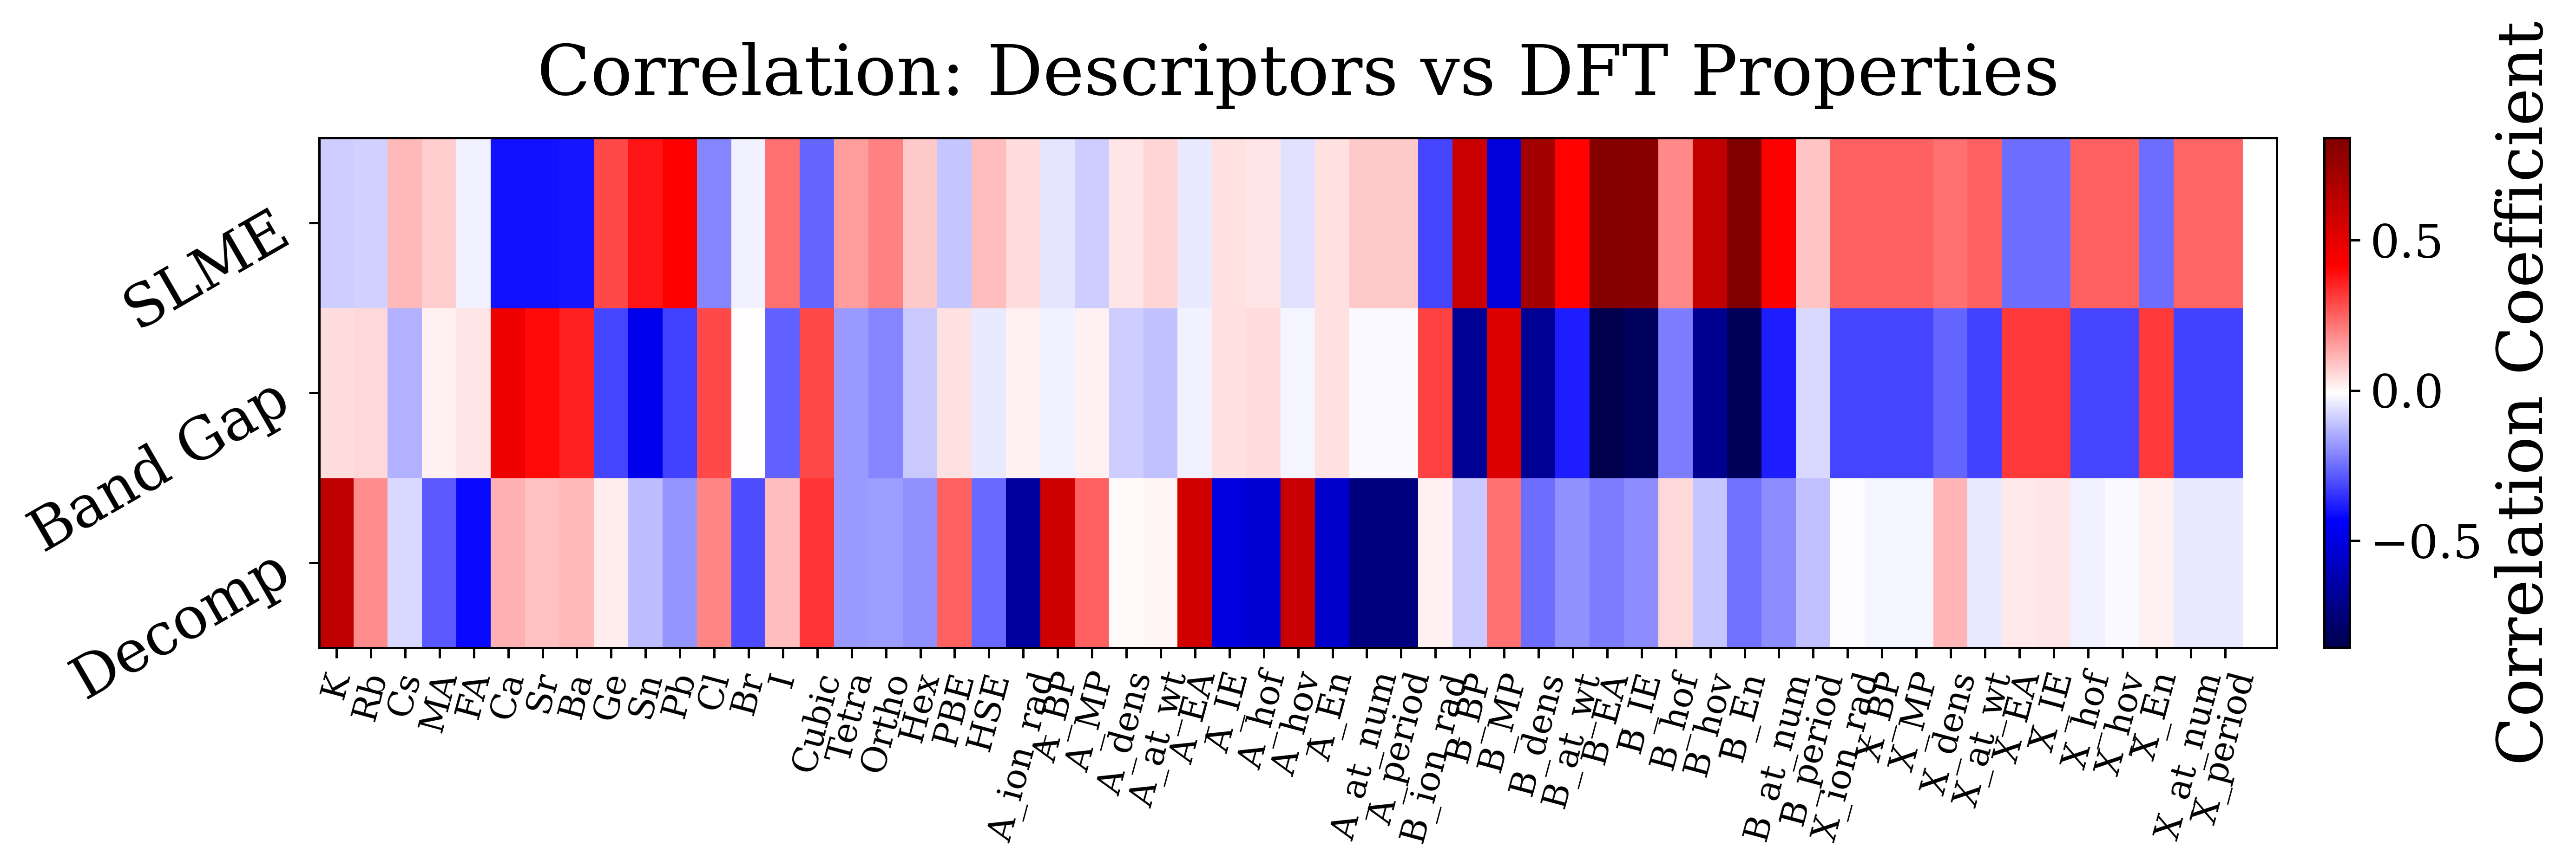

In [92]:
###   Pearson Coefficient of Linear Correlation    ###


##  Read DFT data for this  ##

!wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/main/PBE_and_HSE_data.csv
D_temp = read_csv('PBE_and_HSE_data.csv')
df_temp = pd.DataFrame(D_temp)
Index_temp = df_temp.Index
Formula_temp = df_temp.Formula
Decomp_temp = df_temp.Decomp
Gap_temp = df_temp.Gap
SLME_temp = df_temp.SLME
Comp_desc_temp = pd.DataFrame(D_temp, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
Elem_desc_temp = pd.DataFrame(D_temp, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
All_desc_temp = pd.DataFrame(D_temp, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
X_fl = np.array(All_desc_temp, dtype="float32")
mm = int(All_desc_temp.size/Index_temp.size)

Corr = [[0.0 for a in range(mm)] for b in range(3)]

for i in range(0,mm):
    x = stats.pearsonr(X_fl[:,i], Decomp_temp[:])
    Corr[0][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], Gap_temp[:])
    Corr[1][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], SLME_temp[:])
    Corr[2][i] = x[0]

    
x = np.arange(mm)
xx = [0.0]*mm
for i in range(0,mm):
    xx[i] = x[i]+0.5
y = [0.5,1.5,2.5]
f = 16
r = 75
Prop = ['Decomp', 'Band Gap', 'SLME']


scale = ['linear']
plotposition = [131, 132, 133]

fig=plt.figure(figsize=(12,4),dpi=450)
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.10, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

ax = plt.plot(plotposition[0])
plt.plot(plotposition[0])
plt.xscale(scale[0])
plt.yscale(scale[0])
plt.xlim([0,m])
plt.ylim([0,3])

#Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE']
#Labels = ['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']

plt.xticks(xx[0:m], Labels[0:m], rotation=75, fontsize=12)
plt.yticks(y[:], Prop[:], rotation=30, fontsize=20)
plt.title('Correlation: Descriptors vs DFT Properties', fontname='serif', size=24, horizontalalignment='center', pad=15)
plt.pcolor(Corr, cmap='seismic')
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(label='Correlation Coefficient', size=22)
#plt.savefig('corr.pdf', dpi=450)



In [93]:
###  Function: Training-Test Split  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###

def split_1():
    t = 0.20
    X_train, X_test, Prop_decomp_train, Prop_decomp_test, Prop_gap_train, Prop_gap_test, Prop_slme_train, Prop_slme_test, Index_train, Index_test, Formulas_train, Formulas_test = train_test_split(X, Decomp, Gap, SLME, Index, Formula, test_size=t)
    n_tr = Prop_gap_train.size
    n_te = Prop_gap_test.size
    
    X_train_fl = np.array(X_train, dtype="float32")
    Prop_decomp_train_fl = np.array(Prop_decomp_train, dtype="float32")
    Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
    Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")
    Index_train_fl = np.array(Index_train, dtype="float32")
    
    X_test_fl = np.array(X_test, dtype="float32")
    Prop_decomp_test_fl = np.array(Prop_decomp_test, dtype="float32")
    Prop_gap_test_fl = np.array(Prop_gap_test, dtype="float32")
    Prop_slme_test_fl = np.array(Prop_slme_test, dtype="float32")
    Index_test_fl = np.array(Index_test, dtype="float32")

    return (X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test)


In [94]:
###  Function: Training-Test Split  ###
###  Run this cell for PBE-HSE-Expt mf2 model + GA  ###

def split_2():
    t = 0.20
    X_train_1, X_test_1, Prop_gap_train, Prop_gap_test, Index_train_1, Index_test_1 = train_test_split(X, Gap, Index, test_size=t)
    X_train_2, X_test_2, Prop_slme_train, Prop_slme_test, Index_train_2, Index_test_2 = train_test_split(X_2, SLME, Index_2, test_size=t)
    n_tr = Prop_gap_train.size
    n_te = Prop_gap_test.size
    
    X_train_fl_1 = np.array(X_train_1, dtype="float32")
    X_train_fl_2 = np.array(X_train_2, dtype="float32")
    Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
    Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")
    Index_train_fl_1 = np.array(Index_train_1, dtype="float32")
    Index_train_fl_2 = np.array(Index_train_2, dtype="float32")
    
    X_test_fl_1 = np.array(X_test_1, dtype="float32")
    X_test_fl_2 = np.array(X_test_2, dtype="float32")
    Prop_gap_test_fl = np.array(Prop_gap_test, dtype="float32")
    Prop_slme_test_fl = np.array(Prop_slme_test, dtype="float32")
    Index_test_fl_1 = np.array(Index_test_1, dtype="float32")
    Index_test_fl_2 = np.array(Index_test_2, dtype="float32")

    return (X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2)


In [95]:
###  Function: Define Hyperparameters + Train Random Forest Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def RFR_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
    param_grid = {"n_estimators": [50, 100, 200],
#        "max_features": [10, 20, 40, m],
#        "min_samples_leaf": [5,10,20],
#        "max_depth": [5,10,15],
#        "min_samples_split": [2, 5, 10, 15]
                 }
#    param_grid = {}
    
#  Train Model For Decomposition Energy ##
    rfr_decomp = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = rfr_decomp.predict(X_train_fl)
    Pred_test = rfr_decomp.predict(X_test_fl)
    Pred_expt = rfr_decomp.predict(X_expt_fl)
    Pred_out = rfr_decomp.predict(X_out_fl)
    Pred_all = rfr_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = rfr_gap.predict(X_train_fl)
    Pred_test = rfr_gap.predict(X_test_fl)
    Pred_expt = rfr_gap.predict(X_expt_fl)
    Pred_out = rfr_gap.predict(X_out_fl)
    Pred_all = rfr_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = rfr_slme.predict(X_train_fl)
    Pred_test = rfr_slme.predict(X_test_fl)
    Pred_expt = rfr_slme.predict(X_expt_fl)
    Pred_out = rfr_slme.predict(X_out_fl)
    Pred_all = rfr_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, rfr_decomp, rfr_gap, rfr_slme)



In [96]:
###  Function: Define Hyperparameters + Train Random Forest Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def RFR_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
    param_grid = {"n_estimators": [50, 100, 200],
#        "max_features": [10, 20, 40, m],
#        "min_samples_leaf": [5,10,20],
#        "max_depth": [5,10,15],
#        "min_samples_split": [2, 5, 10, 15]
                 }
#    param_grid = {}

#  Train Model For Band Gap ##
    rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = rfr_gap.predict(X_train_fl_1)
    Pred_test = rfr_gap.predict(X_test_fl_1)
    Pred_expt = rfr_gap.predict(X_expt_fl)
    Pred_out = rfr_gap.predict(X_out_fl)
    Pred_all = rfr_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = rfr_slme.predict(X_train_fl_2)
    Pred_test = rfr_slme.predict(X_test_fl_2)
    Pred_expt = rfr_slme.predict(X_expt_fl)
    Pred_out = rfr_slme.predict(X_out_fl)
    Pred_all = rfr_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, rfr_gap, rfr_slme)



In [97]:
###  Function: Define Hyperparameters + Train Elastic Net Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def ENET_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                  "max_iter": [1e3, 1e4],
                  #"tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
                  "tol": [1e-1]}

#  Train Model For Decomposition Energy ##
    enet_decomp = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = enet_decomp.predict(X_train_fl)
    Pred_test = enet_decomp.predict(X_test_fl)
    Pred_expt = enet_decomp.predict(X_expt_fl)
    Pred_out = enet_decomp.predict(X_out_fl)
    Pred_all = enet_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    enet_gap = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = enet_gap.predict(X_train_fl)
    Pred_test = enet_gap.predict(X_test_fl)
    Pred_expt = enet_gap.predict(X_expt_fl)
    Pred_out = enet_gap.predict(X_out_fl)
    Pred_all = enet_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    enet_slme = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = enet_slme.predict(X_train_fl)
    Pred_test = enet_slme.predict(X_test_fl)
    Pred_expt = enet_slme.predict(X_expt_fl)
    Pred_out = enet_slme.predict(X_out_fl)
    Pred_all = enet_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, enet_decomp, enet_gap, enet_slme)



In [98]:
###  Function: Define Hyperparameters + Train Elastic Net Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def ENET_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                  "max_iter": [1e3, 1e4],
                  #"tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
                  "tol": [1e-1]}

#  Train Model For Band Gap ##
    enet_gap = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = enet_gap.predict(X_train_fl_1)
    Pred_test = enet_gap.predict(X_test_fl_1)
    Pred_expt = enet_gap.predict(X_expt_fl)
    Pred_out = enet_gap.predict(X_out_fl)
    Pred_all = enet_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    enet_slme = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = enet_slme.predict(X_train_fl_2)
    Pred_test = enet_slme.predict(X_test_fl_2)
    Pred_expt = enet_slme.predict(X_expt_fl)
    Pred_out = enet_slme.predict(X_out_fl)
    Pred_all = enet_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, enet_gap, enet_slme)



In [99]:
###  Function: Define Hyperparameters + Train Kernel Ridge Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def KRR_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
    param_grid = {
        "alpha": [1e0, 1e-1, 1e-2, 1e-3],
        #"alpha": [10],
        "kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
    }
    param_grid = {}
    
#  Train Model For Decomposition Energy ##
    krr_decomp = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = krr_decomp.predict(X_train_fl)
    Pred_test = krr_decomp.predict(X_test_fl)
    Pred_expt = krr_decomp.predict(X_expt_fl)
    Pred_out = krr_decomp.predict(X_out_fl)
    Pred_all = krr_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    krr_gap = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = krr_gap.predict(X_train_fl)
    Pred_test = krr_gap.predict(X_test_fl)
    Pred_expt = krr_gap.predict(X_expt_fl)
    Pred_out = krr_gap.predict(X_out_fl)
    Pred_all = krr_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    krr_slme = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = krr_slme.predict(X_train_fl)
    Pred_test = krr_slme.predict(X_test_fl)
    Pred_expt = krr_slme.predict(X_expt_fl)
    Pred_out = krr_slme.predict(X_out_fl)
    Pred_all = krr_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, krr_decomp, krr_gap, krr_slme)



In [102]:
###  Function: Define Hyperparameters + Train Kernel Ridge Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def KRR_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
    param_grid = {
        #"alpha": [1e0, 1e-1, 1e-2, 1e-3],
        #"alpha": [10],
        "kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
    }
    param_grid = {}

#  Train Model For Band Gap ##
    krr_gap = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = krr_gap.predict(X_train_fl_1)
    Pred_test = krr_gap.predict(X_test_fl_1)
    Pred_expt = krr_gap.predict(X_expt_fl)
    Pred_out = krr_gap.predict(X_out_fl)
    Pred_all = krr_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    krr_slme = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = krr_slme.predict(X_train_fl_2)
    Pred_test = krr_slme.predict(X_test_fl_2)
    Pred_expt = krr_slme.predict(X_expt_fl)
    Pred_out = krr_slme.predict(X_out_fl)
    Pred_all = krr_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )

    
    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, krr_gap, krr_slme)



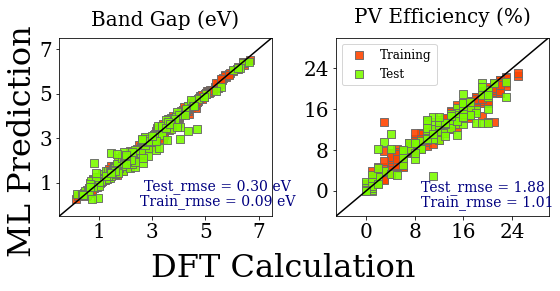

In [105]:
###  Train RFR models on data, visualize using parity plots  ###


#reg = ENET_1
#reg = RFR_1
#reg = KRR_1
#reg = ENET_2
reg = RFR_2
#reg = KRR_2


if Data == 'PBE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Decomp_dft[:], Decomp_ml[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    te = '%.2f' % decomp_rmse
    ax1.text(0.50, -1.35, 'rmse = ' + te + ' eV', c='navy', fontsize=16)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Gaps_dft[:], Gaps_ml[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    te = '%.2f' % gap_rmse
    ax2.text(2.55, 0.4, 'rmse = ' + te + ' eV', c='navy', fontsize=16)
    ax2.set_ylim([0.0, 6.0])
    ax2.set_xlim([0.0, 6.0])
    ax2.set_xticks([1, 2, 3, 4, 5])
    ax2.set_yticks([1, 2, 3, 4, 5])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(SLME_dft[:], SLME_ml[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    te = '%.2f' % slme_rmse
    ax3.text(11, -2.5, 'rmse = ' + te + ' %', c='navy', fontsize=16)
    ax3.set_ylim([-5, 30])
    ax3.set_xlim([-5, 30])
    ax3.set_xticks([0, 8, 16, 24])
    ax3.set_yticks([0, 8, 16, 24])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})
    
#    plt.savefig('plot_PBE_sf.pdf', dpi=450)



if Data == 'HSE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0]) 
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(6, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax3.text(6, -2, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax3.set_ylim([-3, 18])
    ax3.set_xlim([-3, 18])
    ax3.set_xticks([0, 5, 10, 15])
    ax3.set_yticks([0, 5, 10, 15])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})

#    plt.savefig('plot_HSE_sf.pdf', dpi=450)


    
if Data == 'PBE_and_HSE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(9, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax3.text(9, -3, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax3.set_ylim([-5, 30])
    ax3.set_xlim([-5, 30])
    ax3.set_xticks([0, 8, 16, 24])
    ax3.set_yticks([0, 8, 16, 24])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})
    
#    plt.savefig('plot_mf1.pdf', dpi=450)



if Data == 'PBE_HSE_Expt':

    X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2 = split_2()
    Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_gap, reg_slme = reg(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2)

    fig, ( [ax1, ax2] ) = plt.subplots( nrows=1, ncols=2, figsize=(8,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax1.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-0.5, 7.5])
    ax1.set_xlim([-0.5, 7.5])
    ax1.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax1.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax1.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax2.text(9, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax2.text(9, -3, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax2.set_ylim([-5, 30])
    ax2.set_xlim([-5, 30])
    ax2.set_xticks([0, 8, 16, 24])
    ax2.set_yticks([0, 8, 16, 24])
    ax2.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax2.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})
    
#    plt.savefig('plot_mf2.pdf', dpi=450)



In [83]:
def GA(rfr_decomp, rfr_gap, rfr_slme):
    

    x1 = [0.0]*65
    x2 = [0.0]*5
    for i in range(0,65):
        x1[i] = i/64
    for i in range(0,5):
        x2[i] = i/4

#    varbound = np.array([[0,1], [0,1], [0,1], [0,64], [0,1], [0,1], [0,1], [0,1], [0,1], [0,64], [0,64], [0,1], [0,64], [0,64], [0,4], [0,4], [0,4], [0,4] ] )
    varbound = np.array([[0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,64], [0,4], [0,4], [0,4], [0,4] ])
    #labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt']

    def f(XX):
        X_1 = [0.0]*54
        X = [0.0]*57
        Comp = [0.0]*14
        for i in range(0,14):
            X[i] = x1[int(XX[i])]
            X_1[i] = x1[int(XX[i])]
            Comp[i] = X[i]
        for i in range(14,18):
            X[i] = x2[int(XX[i])]
            X_1[i] = x2[int(XX[i])]
        X[18] = 0
        X[19] = 0
        X[20] = 1
        pen = 0
        if np.abs(np.sum(X[0:5]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[0:5]))
        if np.abs(np.sum(X[5:11]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[5:11]))
        if np.abs(np.sum(X[11:14]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[11:14]))
        if np.abs(np.sum(X[14:18]) - 1.0) > 0.0:
            pen = pen + 1000*np.abs(1-np.sum(X[14:18]))
        Elem_desc = desc(Comp)
        for i in range(0,36):
            X[i+21] = Elem_desc[i]
            X_1[i+18] = Elem_desc[i]
        pred_decomp = float(rfr_decomp.predict( np.reshape(X_1, (1, -1)) ))
        pred_slme = float(rfr_slme.predict( np.reshape(X, (1, -1)) ))
        pred_gap = float(rfr_gap.predict( np.reshape(X, (1, -1)) ))
        if pred_decomp > 0.0:
            pen = pen + 1000*np.abs(pred_decomp)
        if pred_gap < 1.0:
            pen = pen + 1000*np.abs(pred_gap - 1)
        if pred_gap > 2.0:
            pen = pen + 1000*np.abs(pred_gap - 2.0)
        if pred_slme < 0.15:
            pen = pen + 1000*np.abs(pred_slme - 0.15)
        return pen


    algorithm_param = {'max_num_iteration': 100,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,  
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'mutation_type': 'uniform_by_center',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

    model = ga(function=f, dimension=18, variable_type='int', variable_boundaries=varbound, variable_type_mixed = None, function_timeout = 10, algorithm_parameters=algorithm_param)
    #model.run()

    model.run(
    no_plot = False, 
    disable_progress_bar = False,
    disable_printing = False,

    set_function = None, 
    apply_function_to_parents = False, 
    start_generation = {'variables':None, 'scores': None},
    studEA = False,
    mutation_indexes = None,

    init_creator = None,
    init_oppositors = None,
    duplicates_oppositor = None,
    remove_duplicates_generation_step = None,
    revolution_oppositor = None,
    revolution_after_stagnation_step = None,
    revolution_part = 0.3,

    population_initializer = Population_initializer(select_best_of = 10, local_optimization_step = 'never', local_optimizer = None),

    stop_when_reached = None,
    callbacks = [],
    middle_callbacks = [],
    time_limit_secs = None, 
    seed = None,
    save_last_generation_as = 'last_gen.txt'
    )


    X_best = [0.0]*57
    X_best_1 = [0.0]*54
    for i in range(0,18):
        X_best[i] = float( x1[int(model.best_variable[i])] )
        X_best_1[i] = float( x1[int(model.best_variable[i])] )
    X_best[18] = 0
    X_best[19] = 0
    X_best[20] = 1
    Comp = [0.0]*14
    for i in range(0,14):
        Comp[i] = X_best[i]
    Elem_desc = desc(Comp)
    for i in range(0,36):
        X_best[i+21] = Elem_desc[i]
        X_best_1[i+18] = Elem_desc[i]

    print ('best_decomp_energy = ', float ( rfr_decomp.predict( np.reshape(X_best_1[:], (1,-1)) ) ))
    print ('best_PCE = ', float ( rfr_slme.predict( np.reshape(X_best[:], (1,-1)) ) ))
    print ('best_band_gap = ', float ( rfr_gap.predict( np.reshape(X_best[:], (1,-1)) ) ))
    
    
    xx = model.output_dict.get('last_generation')
    sc_frac = str(xx.get('variables')[0])
    zz = xx.get('variables')[0]/64
    for i in range(11,14):
        zz[i] = zz[i]*3
    for i in range(14,18):
        zz[i] = zz[i]*16
    formula_best_perovs = [' ']
    atoms = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']
    for i in range(0,14):
        if float(zz[i]) > 0.004:
            ii = '%.2f' % float(zz[i])
            formula_best_perovs[0] = formula_best_perovs[0] + atoms[i] + '_' + str(ii) + ' '
    phase_best_perovs = [' ']
    phases = ['cubic', 'tetra', 'ortho', 'hex']
    for i in range(14,18):
        if float(zz[i]) > 0.004:
            ii = '%.2f' % float(zz[i])
            phase_best_perovs[0] = phase_best_perovs[0] + phases[i-14] + '_' + str(ii) + ' '    

    print ('best_perovs_alloy = ', formula_best_perovs)
    print ('best_perovs_phase = ', phase_best_perovs)
    
    pred_best_prop = "best_decomp_energy = " + str(float(rfr_decomp.predict( np.reshape(X_best_1[:], (1, -1)) ))) + "  " + "best_gap = " + str(float(rfr_gap.predict( np.reshape(X_best[:], (1, -1)) ))) + "  " + "  " + "best_PCE = " + str(float(rfr_slme.predict( np.reshape(X_best[:], (1, -1)) )))
    
    pred_best_compound = formula_best_perovs
    pred_best_phase = phase_best_perovs
    
    return pred_best_prop, pred_best_compound, pred_best_phase, sc_frac, X_best
    

# text_file = open("results.txt", "w")
# text_file.write("rmse_test_decomp: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) ) + '\n')
# text_file.write("rmse_train_decomp: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) ) + '\n')
# text_file.write("rmse_test_slme: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) ) + '\n')
# text_file.write("rmse_train_slme: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) ) + '\n')
# text_file.write("rmse_test_gap: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) ) + '\n')
# text_file.write("rmse_train_gap: %s" % np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) ) + '\n')
# text_file.write(":: %s" % '  ' + '\n')
# text_file.write("best_decomp_energy: %s" % float(rfr_decomp.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_PV_SLME: %s" % float(rfr_slme.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_band_gap: %s" % float(rfr_gap.predict( np.reshape(X_best[:], (1, -1)) )) + '\n')
# text_file.write("best_perovs_alloy: %s" % formula_best_perovs + '\n')
# text_file.close()

# np.savetxt('scores.txt', model.report)

# # plot and save optimization process plot
# model.plot_results(save_as = 'plot_scores_process.png')

# # plot scores of last population
# model.plot_generation_scores(title = 'Population scores after ending of searching', save_as= 'plot_scores_end.png')





 Average time of function evaluating (secs): 0.029429795026779174

                                                                                                                                                                                                        
 The best found solution:
 [ 2.  2. 19.  1. 39.  6.  3.  4. 13. 29. 10. 14. 25. 27.  4.  0.  0.  0.]

 Objective function:
 65.69999931380153

 Used generations: 101
 Used time: 212 seconds


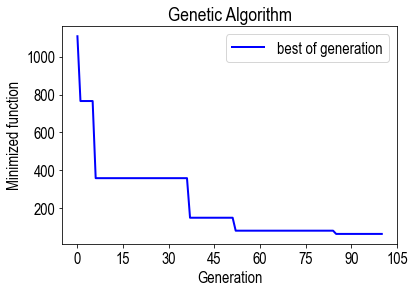

best_decomp_energy =  -0.26139999940991404
best_PCE =  0.14680000068619847
best_band_gap =  1.93009998857975
best_perovs_alloy =  [' K_0.03 Rb_0.03 Cs_0.30 MA_0.02 FA_0.61 Ca_0.09 Sr_0.05 Ba_0.06 Ge_0.20 Sn_0.45 Pb_0.16 Cl_0.66 Br_1.17 I_1.27 ']
best_perovs_phase =  [' cubic_1.00 ']

 Average time of function evaluating (secs): 0.02615869665145874

                                                                                                                                                                                                        
 The best found solution:
 [ 4.  3. 15. 18. 25.  0.  9. 14. 17. 12. 14. 15. 11. 40.  1.  1.  0.  2.]

 Objective function:
 89.14499991387129

 Used generations: 101
 Used time: 203 seconds


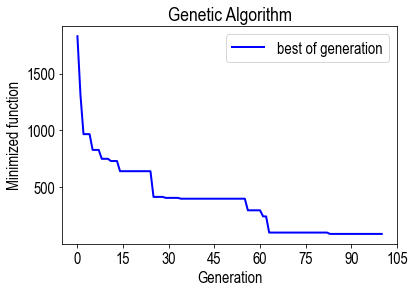

best_decomp_energy =  -0.026799999997019767
best_PCE =  0.1435799999833107
best_band_gap =  1.9372999960184096
best_perovs_alloy =  [' K_0.06 Rb_0.05 Cs_0.23 MA_0.28 FA_0.39 Sr_0.14 Ba_0.22 Ge_0.27 Sn_0.19 Pb_0.22 Cl_0.70 Br_0.52 I_1.88 ']
best_perovs_phase =  [' cubic_0.25 tetra_0.25 hex_0.50 ']


In [84]:
times = 2

dim = m
pred_prop = ['s']*times
pred_comp = ['s']*times
pred_phase = ['s']*times
sc_frac = ['s']*times
#X_b = [0.0]*dim
X_best = [[0.0 for a in range(times)] for b in range(dim)]

for i in range(0,times):
    t = 0.2
    
    X_train, X_test, Prop_decomp_train, Prop_decomp_test = train_test_split(X_1, Decomp, test_size=t)
    X_train_fl = np.array(X_train, dtype="float32")
    Prop_decomp_train_fl = np.array(Prop_decomp_train, dtype="float32")
    param_grid = {}
    rfr_decomp = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    
    X_train, X_test, Prop_gap_train, Prop_gap_test = train_test_split(X_2, Gap, test_size=t)
    X_train_fl = np.array(X_train, dtype="float32")
    Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
    param_grid = {}
    rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_gap.fit(X_train_fl, Prop_gap_train_fl)    

    X_train, X_test, Prop_slme_train, Prop_slme_test = train_test_split(X_3, SLME, test_size=t)
    X_train_fl = np.array(X_train, dtype="float32")
    Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")
    param_grid = {}
    rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_slme.fit(X_train_fl, Prop_slme_train_fl)
    dim = int (X_3.size/SLME.size)
    
    pred_prop[i], pred_comp[i], pred_phase[i], sc_frac[i], X_b = GA(rfr_decomp, rfr_gap, rfr_slme)
    for j in range(0,dim):
        X_best[j][i] = X_b[j]


text_file = open("pred_prop.txt", "w")
for i in range(0,times):
    text_file.write("Predicted properties: %s" % pred_prop[i] + '\n')
text_file.close()

text_file = open("pred_comp.txt", "w")
for i in range(0,times):
    text_file.write("Composition: %s" % pred_comp[i] + '\n')
text_file.close()

text_file = open("pred_phase.txt", "w")
for i in range(0,times):
    text_file.write("Phase: %s" % pred_phase[i] + '\n')
text_file.close()

text_file = open("supercell_fractions.txt", "w")
for i in range(0,times):
    text_file.write("Integer 18-dim vector: %s" % sc_frac[i] + '\n')
text_file.close()


aa = [0.0]*14
bb = [0.0]*14
for i in range(0,11):
    aa[i] = i
    for j in range(0,times):
        bb[i] = bb[i] + X_best[i][j]
    bb[i] = bb[i]/times
for i in range(11,14):
    aa[i] = i
    for j in range(0,times):
        bb[i] = bb[i] + X_best[i][j]/3
    bb[i] = bb[i]/times
#plt.scatter(aa, bb)


# fig=plt.figure(figsize=(10,4),dpi=450)
# plt.rcParams.update({'font.size': 16})
# plt.rc('font', family='Arial narrow')
# plt.subplots_adjust(left=0.21, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

# ax = plt.plot(plotposition[0])
# plt.plot(plotposition[0])
# plt.xscale(scale[0])
# plt.yscale(scale[0])
# #plt.xlim([0,m])
# plt.ylim([0,1])

# xx = [0.0]*14
# for i in range(0,14):
#     xx[i] = i
# Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']

# plt.xticks(xx[:], Labels[:], rotation=90, fontsize=12)
# #plt.title('...', fontname='Arial narrow', size=24, horizontalalignment='center', pad=15)
# plt.bar(aa, bb, color ='r', width = 0.9, edgecolor ='grey', align='center')

# plt.savefig('GA_fracs.pdf', dpi=450)
